In [1]:
import jax.numpy as np
import jax.random as jnp_random
import numpy.random as npr
import numpy as onp
from jax import grad, jacrev, jacfwd, jit, vmap, partial
from jax.nn import relu
from jax.lax import scan, cond
from jax.ops import index, index_add, index_update
from jax.flatten_util import ravel_pytree
from jax.scipy.special import logsumexp
from jax.numpy import concatenate as cat
from jax.experimental import stax, optimizers
from jax.nn.initializers import normal

import random
import pickle as pkl
import scipy

from IPython.display import clear_output
import matplotlib.pyplot as plt


# import dynamics f(x, u) and equilibrium policy pi
# importing the lunar lander dynamics and stabilization policy pi 
from mylunarlander import f, pi

/home/burn/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
@jit
def p(x): # target distribution
    s = x[:2]
    x1 = s-np.array([0.7, 0.5])
    x2 = s+np.array([-0.4, 0.3])
    x3 = s-np.array([-0.7, 0.6])

    return np.exp(-0.5*np.sum((x1/0.19)**2)) \
            + np.exp(-0.5*np.sum((x2/0.15)**2)) \
            + np.exp(-0.5*np.sum((x3/0.4)**2)) \

@jit
def dist(x, s): # log pdf on individual point in robot trajectory
    dx = x[:2]-s
    return -0.5 * np.sum((dx/0.1)**2)

def kle3_rollout(x, u):
    u_eq = pi(x) + u
    x = f(x, u_eq)
    return x, x

logexp_vmap = lambda _x, _s: logsumexp(vmap(dist, in_axes=(0, None))(_x, _s))

def kle3_loss(u, x0, si):
    xf, tr = scan(kle3_rollout, x0, u)
    logqi = vmap(partial(logexp_vmap, tr))(si)
    pi = vmap(p)(si)
    pi = pi/(np.sum(pi) + 1e-3) # normalize
    ell = -np.sum(logqi*pi)
    return ell + 1e-5*np.mean(u**2)

djdu = jit(grad(kle3_loss))
def kle3(u, x0, key, epochs=20, lr=1e-1):
    si = jnp_random.uniform(key, shape=(60,2), minval=-1., maxval=1.)
    for e in range(epochs):
        u = u - lr * djdu(u, x0, si)
    return u


In [3]:

u = np.zeros((100, 2))
x0 = np.zeros(6)
traj = []

key = jnp_random.PRNGKey(0)
random.seed(0)

for t in range(500):
    traj.append(x0.copy())
    key, subkey = jnp_random.split(key)
    u = kle3(u, x0, subkey)    
    u_eq = pi(x0) + u[0]
    x0 = f(x0, u_eq)
    u = index_update(u, index[:-1,:], u[1:,:])
    u = index_update(u, index[-1,:], u[-1])
    

Text(0.5, 1.0, 'robot trajectory')

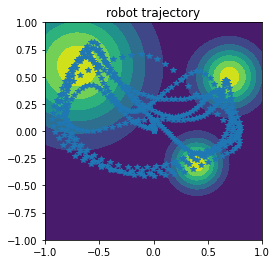

In [4]:
traj = np.stack(traj)
X, Y = onp.meshgrid(*[np.linspace(-1,1)]*2)
x_pts = np.stack([X.ravel(), Y.ravel()]).T
p_eval = vmap(p, )(x_pts).reshape(X.shape)
plt.contourf(X, Y, p_eval)
plt.plot(traj[:,0], traj[:,1], '*')
plt.axis('equal')
plt.axis('square')
plt.title('robot trajectory')


In [ ]:
x